## Preprocess Data

In [1]:
import re

def clean_xml(file_path, output_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    content = content.replace('&', '&amp;')
    content = content.replace(')', '&#41;')
    content = content.replace('(', '&#40;')

    def clean_text(match):
        text_content = match.group(1) 
        text_content = text_content.replace('>', '&gt;')
        text_content = text_content.replace('<', '&lt;')
        text_content = text_content.replace('"', '&quot;')
        text_content = text_content.replace("'", '&apos;')
        return f"<text>{text_content}</text>"
    
    content = re.sub(r"<text>(.*?)</text>", clean_text, content, flags=re.DOTALL)
    
    with open(output_path, 'w', encoding='utf-8') as file:
        file.write(content)                                     

        
clean_xml('/kaggle/input/train-ds310/train-ds310.xml', '/kaggle/working/cleaned_train.xml')
clean_xml('/kaggle/input/test-ds310/test-ds310.xml', '/kaggle/working/cleaned_test.xml')

In [2]:
import yaml
data = {
    'base_path': '/kaggle/working/',
    'train_file': 'cleaned_train.xml',
    'lowercase': True,
    'remove_list': [
        'conflict'
    ]
}

file_path = "config_train.yaml"
with open(file_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

import yaml
data = {
    'base_path': '/kaggle/working/',
    'train_file': 'cleaned_test.xml',
    'lowercase': True,
    'remove_list': [
        'conflict'
    ]
}
file_path = "config_test.yaml"
with open(file_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

In [4]:
import os
import pickle
import argparse
from lxml import etree
from tqdm import tqdm
from transformers import BertTokenizer
import yaml

def parse_xml(path, lowercase=False, remove_list=None):
    if remove_list is None:
        remove_list = []
    dataset = []
    with open(path, 'rb') as f:
        root = etree.fromstring(f.read())
        for sentence in root:
            index = sentence.get('id')
            sent = sentence.find('text').text
            if lowercase:
                sent = sent.lower()
            terms = sentence.find('aspectTerms')
            if terms is None:
                continue
            accept_terms = []
            for term in terms:
                aspect = term.attrib['term']
                sentiment = term.attrib['polarity']
                implicit = term.attrib.get('implicit_sentiment', '') == "True"
                if sentiment in remove_list:
                    continue
                left_index = int(term.attrib['from'])
                right_index = int(term.attrib['to'])
                accept_terms.append({
                    'aspect_term': aspect,
                    'sentiment': sentiment,
                    'implicit': implicit,
                    'left_index': left_index,
                    'right_index': right_index,
                })
            if accept_terms:
                dataset.append({
                    'id': index,
                    'text': sent,
                    'aspect_terms': accept_terms,
                })
    return dataset

def preprocess_finetune(dataset, max_token_size=512):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    sentiment_dict = {
        'positive': 0,
        'negative': 1,
        'neutral': 2,
    }
    raw_texts, raw_aspect_terms, bert_tokens = [], [], []
    aspect_masks, implicits, labels = [], [], []

    for data in tqdm(dataset):
        token = tokenizer.tokenize(data['text'])
        for aspect in data['aspect_terms']:
            bert_token = tokenizer.convert_tokens_to_ids(['[CLS]'] + token + ['[SEP]'])
            left_idx = len(tokenizer.tokenize(data['text'][:aspect['left_index']])) + 1
            length = len(tokenizer.tokenize(data['text'][aspect['left_index']: aspect['right_index']]))
            aspect_mask = [0] * len(bert_token)
            aspect_mask[left_idx: left_idx + length] = [1] * length

            if len(bert_token) >= max_token_size:
                continue

            raw_texts.append(data['text'])
            raw_aspect_terms.append(aspect['aspect_term'])
            bert_tokens.append(bert_token)
            aspect_masks.append(aspect_mask)
            implicits.append(aspect['implicit'])
            labels.append(sentiment_dict[aspect['sentiment']])
    print(raw_texts)
    print(raw_aspect_terms)
    dataset = {
        'raw_texts': raw_texts,
        'raw_aspect_terms': raw_aspect_terms,
        'bert_tokens': bert_tokens,
        'aspect_masks': aspect_masks,
        'implicits': implicits,
        'labels': labels,
    }
    return dataset

def preprocess_and_save(config_file, output_path):
    with open(config_file, 'r') as file:
        config = yaml.safe_load(file)

    base_path = config['base_path']
    train_path = os.path.join(base_path, config['train_file'])
    lowercase = config.get('lowercase', False)
    remove_list = config.get('remove_list', [])
    
    train_data = parse_xml(train_path, lowercase=lowercase, remove_list=remove_list)
    processed_data = preprocess_finetune(train_data)
    save_path = os.path.join(output_path, 'processed_data_train.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(processed_data, f)


if __name__ == "__main__":
    config_file = "/kaggle/working/config_train.yaml"
    output_path = "/kaggle/working/"
    os.makedirs(output_path, exist_ok=True)
    preprocess_and_save(config_file, output_path)

100%|██████████| 395/395 [00:00<00:00, 1431.26it/s]

['giá 53k size vừa.', 'giá 53k size vừa.', 'nhưng nói chung cũng hơi đắt.', 'mình ăn rất hôi mùi dầu.', 'mình ăn chưa baoh thấy mùi hôi hải sản.', '3 dĩa vs 2 lon revive mà có 190k thui&#40;.', 'ở đây ngay khu vắng nên khách cũng không đông mấy.', 'ở đây ngay khu vắng nên khách cũng không đông mấy.', 'quán đông lắm, gọi món phải đợi hơi lâu, ko biết phải tại mình đi trễ ko, nhưng mà nghe nói ở đây giờ nào cũng đông cũng phải ngồi đợi một lúc hết.', 'quán đông lắm, gọi món phải đợi hơi lâu, ko biết phải tại mình đi trễ ko, nhưng mà nghe nói ở đây giờ nào cũng đông cũng phải ngồi đợi một lúc hết.', 'mình uống trà sữa lài hạnh nhân khá thơm nha, vị hạnh nhân không đậm mấy nhưng mùi lài khá thơm, đậm vị trà hơi đắng nhẹ, độ ngọt vừa phải.', 'mình uống trà sữa lài hạnh nhân khá thơm nha, vị hạnh nhân không đậm mấy nhưng mùi lài khá thơm, đậm vị trà hơi đắng nhẹ, độ ngọt vừa phải.', 'mình uống trà sữa lài hạnh nhân khá thơm nha, vị hạnh nhân không đậm mấy nhưng mùi lài khá thơm, đậm vị trà h

## THOR

In [2]:
!git clone https://github.com/QuanThaiX/THOR.git

Cloning into 'THOR'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 165 (delta 77), reused 76 (delta 20), pack-reused 0 (from 0)
Receiving objects: 100% (165/165), 2.49 MiB | 20.53 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [4]:
import os
os.chdir('/kaggle/working/THOR')

In [5]:
!conda create -n thor python=3.8 -y

Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - nodefaults
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.9.0
    latest version: 24.11.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda/envs/thor

  added / updated specs:
    - python=3.8


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |            2_gnu          23 KB  conda-forge
    bzip2-1.0.8                |       h4bc722e_7         247 KB  conda-forge
    ca-certificates-2024.12.14 |       hbcca054_0         153 KB  conda-forge
    ld_impl_linux-64-2.43      |       h712a8e2_2         654 KB  conda-forge
    libgcc-14.2.0  

In [6]:
!conda info --envs
!source /opt/conda/bin/activate thor

# conda environments:
#
base                     /opt/conda
thor                     /opt/conda/envs/thor



In [7]:
import os
os.environ['LD_LIBRARY_PATH'] = '/opt/conda/envs/thor/lib:' + os.environ.get('LD_LIBRARY_PATH', '')
!echo $LD_LIBRARY_PATH

/opt/conda/envs/thor/lib:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib


In [8]:
!/opt/conda/envs/thor/bin/python3 --version
!echo 'print("Hello, World!")' > test.py
!/opt/conda/envs/thor/bin/python3 test.py

Python 3.8.20
Hello, World!


In [9]:
import os
os.chdir('/kaggle/working/THOR')

In [10]:
!/opt/conda/envs/thor/bin/pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 155.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 143.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 142.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 45.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 79.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 150.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 148.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 38.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 23.7 MB/s eta 0:00:0000:0100

In [11]:
import yaml

def update_and_save_config(file_path, new_config):
    try:
        with open(file_path, 'r') as file:
            config = yaml.safe_load(file)
        config.update(new_config)
        with open(file_path, 'w') as file:
            yaml.dump(config, file, default_flow_style=False, sort_keys=False)
    
    except FileNotFoundError:
        with open(file_path, 'w') as file:
            yaml.dump(new_config, file, default_flow_style=False, sort_keys=False)
    except Exception as e:
        print(f"Lỗi: {e}")

config_file = '/kaggle/working/THOR/config/config.yaml'

new_configuration = {
    'data_dir': 'data',
    'preprocessed_dir': 'data/preprocessed',
    'target_dir': 'data/save',
    'model_path': 'VietAI/vit5-base',
    'model_size': 'base',
    'label_list': ['positive', 'negative', 'neutral'],
    'emb_dim': 300,
    'output_channels': 100,
    'speaker_emb_dims': 300,
    'project_dims': 300,
    'max_length': 300,
    'batch_size': 4,
    'epoch_size': 20,
    'train_mode': 'random',
    'filters': [3, 4, 5],
    'dropout': 0.5,
    'shuffle': True,
    'learning_rate': 1e-4,
    'bert_lr': 2e-4,
    'patience': 100,
    'max_grad_norm': 1.0,
    'warmup_proportion': 0.1,
    'gradient_accumulation_steps': 1,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'weight_decay': 0.01,
    'seed': 42
}

update_and_save_config(config_file, new_configuration)

In [15]:
!/opt/conda/envs/thor/bin/python3 main.py -c 0 -r thor -d ds310

/opt/conda/envs/thor/lib/python3.8/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
tokenizer_config.json: 100%|████████████████| 2.20k/2.20k [00:00<00:00, 245kB/s]
spiece.model: 100%|██████████████████████████| 820k/820k [00:00<00:00, 44.8MB/s]
tokenizer.json: 100%|██████████████████████| 2.40M/2.40M [00:00<00:00, 2.45MB/s]
special_tokens_map.json: 100%|█████████████| 2.12k/2.12k [00:00<00:00, 1.29MB/s]
Transformed: giá 53k size vừa., Giá, 2, 1
Transformed: giá 53k size vừa., size, 2, 0
Transformed: nhưng nói chung cũng hơi đắt., giá cả, 1, 1
Transformed: mình ăn rất hôi mùi dầu., mùi dầu, 1, 0
Transformed: mình ăn chưa baoh thấy mùi hôi hải sản., mùi hải sản, 0, 0
Transformed: 3 dĩa vs 2 lon revive mà có 190k thui(., 3 dĩa vs 2 lon Revive, 2, 1
Transformed: ở đây ngay khu vắng nê

In [19]:
import os
import torch
import torch.nn as nn
from transformers import T5ForConditionalGeneration, AutoTokenizer, AutoModelForCausalLM
from src.utils import (
    prompt_for_aspect_inferring,
    prompt_for_opinion_inferring,
    prompt_for_polarity_inferring,
    prompt_for_polarity_label,
)

class Config:
    def __init__(self):
        self.model_path = "VietAI/vit5-base"
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.label_list = ["negative", "neutral", "positive"]
        self.max_length = 512
        self.checkpoint_path = "/kaggle/input/vie_vit5_e11/pytorch/default/1/base_ds310_11.pth.tar"
        self.load_in_16bit = False

config = Config()
tokenizer = AutoTokenizer.from_pretrained(config.model_path)
model = T5ForConditionalGeneration.from_pretrained(config.model_path)
checkpoint = torch.load(config.checkpoint_path, map_location=config.device)
state_dict = {
    k.replace("engine.", ""): v
    for k, v in checkpoint["model"].items()
}
model.load_state_dict(state_dict, strict=False)
model.to(config.device)
model.eval()

/tmp/ipykernel_30/4095382033.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config.checkpoint_path, map_location=config.device)


T5ForConditionalGeneration(
  (shared): Embedding(36096, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36096, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [41]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('THOR/data/save/base_ds310_10.pth.tar')

/kaggle/working


/kaggle/working/THOR/data/save/base_ds310_10.pth.tar

In [13]:
def process_text_and_aspect(model, tokenizer, config, text, aspect):
    results = {}

    # Step 1: Aspect Inferring
    step_one_prompt = prompt_for_aspect_inferring(text, aspect)[1]
    step_one_input = tokenizer(step_one_prompt, return_tensors="pt", max_length=config.max_length, truncation=True)
    step_one_input = {k: v.to(config.device) for k, v in step_one_input.items()}
    step_one_output = model.generate(**step_one_input)
    step_one_result = tokenizer.decode(step_one_output[0], skip_special_tokens=True)
    results['step_one'] = step_one_result

    # Step 2: Opinion Inferring
    step_two_prompt = prompt_for_opinion_inferring(text, aspect, step_one_result)[1]
    step_two_input = tokenizer(step_two_prompt, return_tensors="pt", max_length=config.max_length, truncation=True)
    step_two_input = {k: v.to(config.device) for k, v in step_two_input.items()}
    step_two_output = model.generate(**step_two_input)
    step_two_result = tokenizer.decode(step_two_output[0], skip_special_tokens=True)
    results['step_two'] = step_two_result

    # Step 3: Polarity Inferring
    step_three_prompt = prompt_for_polarity_inferring(text, aspect, step_two_result)[1]
    step_three_input = tokenizer(step_three_prompt, return_tensors="pt", max_length=config.max_length, truncation=True)
    step_three_input = {k: v.to(config.device) for k, v in step_three_input.items()}
    step_three_output = model.generate(**step_three_input)
    step_three_result = tokenizer.decode(step_three_output[0], skip_special_tokens=True)
    results['step_three'] = step_three_result

    # Step 4: Polarity Label
    step_label_prompt = prompt_for_polarity_label(text, step_three_result)
    step_label_input = tokenizer(step_label_prompt, return_tensors="pt", max_length=config.max_length, truncation=True)
    step_label_input = {k: v.to(config.device) for k, v in step_label_input.items()}
    step_label_output = model.generate(**step_label_input)
    final_result = tokenizer.decode(step_label_output[0], skip_special_tokens=True)
    results['final_result'] = final_result

    return results

In [21]:
text = "Đầu bếp ăn món mình nấu chưa"
aspect = "Đầu bếp"

results = process_text_and_aspect(model, tokenizer, config, text, aspect)
for step, output in results.items():
    print(f"{step}: {output}")

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


step_one: negative
step_two: negative
step_three: negative
final_result: negative


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, labels, title, save_path=None):

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Sentence ID: 1
  Text: Món ăn được mang lên chỉ sau vài phút đặt món.
  Aspect: Món ăn
  True Label: positive
  Predicted Label: neutral
  Correct: No
  Category: implicit
--------------------------------------------------
Sentence ID: 2
  Text: Phần ăn không quá ít, cũng không nhiều.
  Aspect: Phần ăn
  True Label: neutral
  Predicted Label: negative
  Correct: No
  Category: implicit
--------------------------------------------------
Sentence ID: 3
  Text: Bàn ghế được lau dọn thường xuyên thì phải.
  Aspect: bàn ghế
  True Label: positive
  Predicted Label: neutral
  Correct: No
  Category: implicit
--------------------------------------------------
Sentence ID: 4
  Text: Không gian tạm ổn, không có gì nổi bật.
  Aspect: không gian
  True Label: neutral
  Predicted Label: neutral
  Correct: Yes
  Category: explicit
--------------------------------------------------
Sentence ID: 5
  Text: Phục vụ quá chậm, đợi mãi mới có món.
  Aspect: phục vụ
  True Label: negative
  Predicted Label

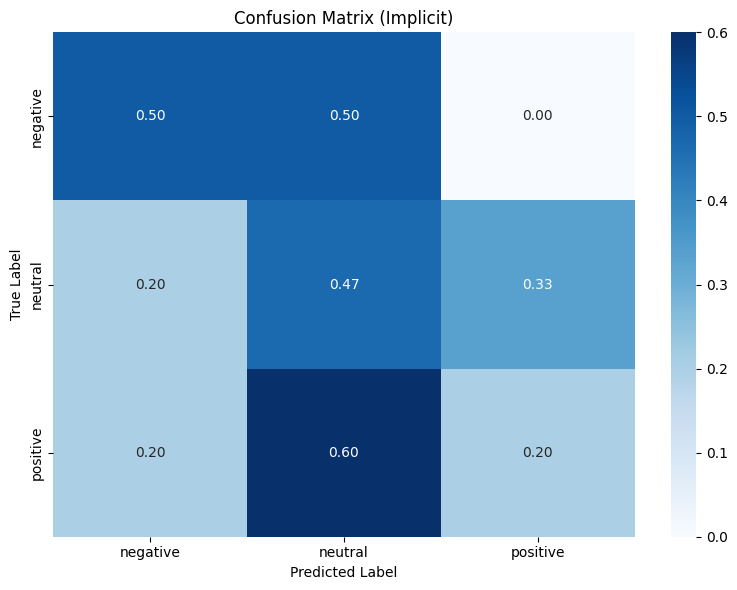

Plotting confusion matrix for explicit...


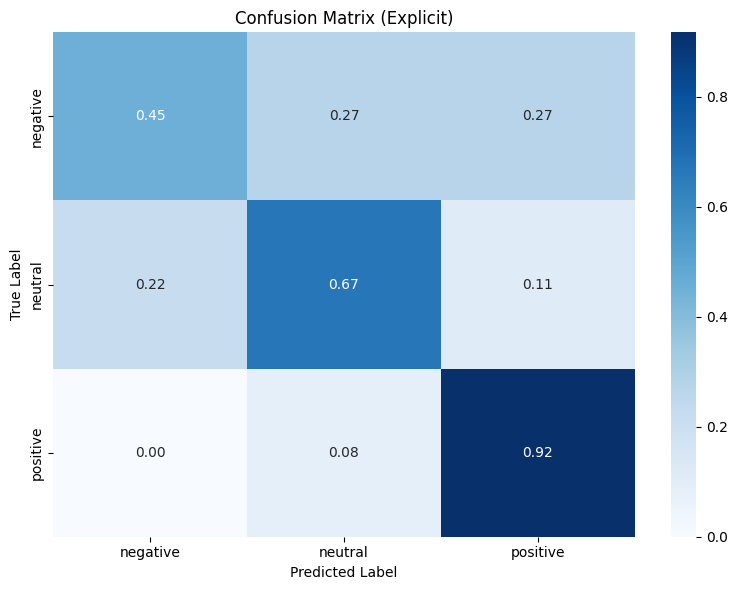


=== Summary Metrics ===
Category: implicit
  F1 Score: 0.390
  Precision: 0.400
  Recall: 0.389
  Accuracy: 0.405
  Count: 37
Category: explicit
  F1 Score: 0.667
  Precision: 0.683
  Recall: 0.679
  Accuracy: 0.688
  Count: 32


In [23]:
import xml.etree.ElementTree as ET
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from collections import defaultdict

def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    data = []
    for sentence in root.findall('sentence'):
        text = sentence.find('text').text
        aspects = sentence.find('aspectTerms')
        if aspects is not None:
            for aspect in aspects.findall('aspectTerm'):
                term = aspect.get('term')
                polarity = aspect.get('polarity')
                implicit_sentiment = aspect.get('implicit_sentiment') == "True"
                data.append({
                    'text': text,
                    'aspect': term,
                    'polarity': polarity,
                    'implicit_sentiment': implicit_sentiment
                })
    return data


def evaluate_model(model, tokenizer, config, data):
    true_labels = defaultdict(list)
    pred_labels = defaultdict(list)
    counts = defaultdict(int)
    results_per_sentence = []

    for idx, entry in enumerate(data, 1):
        text = entry['text']
        aspect = entry['aspect']
        true_label = entry['polarity']
        implicit_sentiment = entry['implicit_sentiment']

        results = process_text_and_aspect(model, tokenizer, config, text, aspect)
        predicted_label = results['final_result']

        category = "implicit" if implicit_sentiment else "explicit"
        true_labels[category].append(true_label)
        pred_labels[category].append(predicted_label)
        counts[category] += 1
        is_correct = true_label == predicted_label

        sentence_result = {
            'sentence_id': idx,
            'text': text,
            'aspect': aspect,
            'true_label': true_label,
            'predicted_label': predicted_label,
            'is_correct': is_correct,
            'category': category
        }
        results_per_sentence.append(sentence_result)

        print(f"Sentence ID: {idx}")
        print(f"  Text: {text}")
        print(f"  Aspect: {aspect}")
        print(f"  True Label: {true_label}")
        print(f"  Predicted Label: {predicted_label}")
        print(f"  Correct: {'Yes' if is_correct else 'No'}")
        print(f"  Category: {category}")
        print("-" * 50)

    # metrics = {}
    # for category in ['implicit', 'explicit']:
    #     metrics[category] = {
    #         'f1': f1_score(true_labels[category], pred_labels[category], average='macro', labels=["negative", "neutral", "positive"]),
    #         'precision': precision_score(true_labels[category], pred_labels[category], average='macro', labels=["negative", "neutral", "positive"]),
    #         'recall': recall_score(true_labels[category], pred_labels[category], average='macro', labels=["negative", "neutral", "positive"]),
    #         'accuracy': accuracy_score(true_labels[category], pred_labels[category]),
    #         'count': counts[category]
    #     }

    metrics = {}
    for category in ['implicit', 'explicit']:
        y_true = true_labels[category]
        y_pred = pred_labels[category]
        
        metrics[category] = {
            'f1': f1_score(y_true, y_pred, average='macro', labels=["negative", "neutral", "positive"]),
            'precision': precision_score(y_true, y_pred, average='macro', labels=["negative", "neutral", "positive"]),
            'recall': recall_score(y_true, y_pred, average='macro', labels=["negative", "neutral", "positive"]),
            'accuracy': accuracy_score(y_true, y_pred),
            'count': counts[category]
        }
    
        print(f"Plotting confusion matrix for {category}...")
        plot_confusion_matrix(
            y_true=y_true,
            y_pred=y_pred,
            labels=["negative", "neutral", "positive"],
            title=f"Confusion Matrix ({category.capitalize()})"
        )

    return metrics, results_per_sentence

file_path = '/kaggle/input/test-ds310/test-ds310.xml'
data = parse_xml(file_path)
metrics, results_per_sentence = evaluate_model(model, tokenizer, config, data)

print("\n=== Summary Metrics ===")
for category, values in metrics.items():
    print(f"Category: {category}")
    print(f"  F1 Score: {values['f1']:.3f}")
    print(f"  Precision: {values['precision']:.3f}")
    print(f"  Recall: {values['recall']:.3f}")
    print(f"  Accuracy: {values['accuracy']:.3f}")
    print(f"  Count: {values['count']}")